# Modeling

This notebook uses a wide variety of modeling algorithms for a binary classification problem. It reads a file created from a feature selection process that has a reasonably small number of good variables, and we know their order of multivariate importance because we used a proper wrapper method. We can explore # input variables, model algorithms and tune model hyperparameters. At the end we can select our favorite algorithm, run it again and build the final model performace score percentile tables.

Here we call the larger fraction population the goods and the smaller fraction the bads. This notebook was originally
written for fraud detection but can be used for any binary classification. It uses detection rate as an appropriate measure of goodness.

Rather than use a built-in CV, we do a "manual CV" by running each model multiple (nitermax) times and average the performance on the training (trn), testing (tst) and out of time (oot) data sets.

Some of the ML algorithms are very fast and some are slow. Feel free to comment out any cells/models you want. At the bottom of the notebook you can select your final model/hyperparameters to run one time only and then make the business perfoemance tables for that final model.

Things to add: better calculation of FDR@3% when building a model using sampled training data. Right now I just approximate it by using the entire population trntst for a model built with sampled data.

In [1]:
#!pip install xgboost

In [2]:
from datetime import datetime
start_time = datetime.now()

import pandas as pd
import random
import xgboost as xgb
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from sklearn.decomposition import PCA
import gc
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline

/home/rchatterjee/.local/lib/python3.9/site-packages/dask/dataframe/__init__.py:31: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [3]:
%%time
vars = pd.read_csv('vars_final.csv')
print(vars.shape)
vars.head()

(97496, 22)
CPU times: user 185 ms, sys: 38.3 ms, total: 223 ms
Wall time: 222 ms


,Cardnum_unique_count_for_card_state_1,Card_Merchdesc_State_total_7,Cardnum_count_1_by_30,Cardnum_max_14,Card_dow_vdratio_0by60,Card_dow_vdratio_0by14,Merchnum_desc_State_total_3,Card_Merchdesc_total_7,Card_dow_unique_count_for_merch_zip_7,Cardnum_actual/toal_0,...,Cardnum_unique_count_for_card_state_3,Cardnum_unique_count_for_card_zip_3,Merchnum_desc_Zip_total_3,Cardnum_unique_count_for_Merchnum_3,Cardnum_actual/toal_1,Cardnum_unique_count_for_card_state_7,Cardnum_actual/max_0,Card_dow_unique_count_for_merch_state_1,Recnum,Fraud
0,1,3.62,0.033333,3.62,0.000011,0.000049,3.62,3.62,1,1.0,...,1,1,3.62,1,1.0,1,1.0,1,1,0
1,1,31.42,0.033333,31.42,0.000011,0.000049,31.42,31.42,1,1.0,...,1,1,31.42,1,1.0,1,1.0,1,2,0
2,1,178.49,0.033333,178.49,0.000011,0.000049,178.49,178.49,1,1.0,...,1,1,178.49,1,1.0,1,1.0,1,3,0
3,1,3.62,0.033333,3.62,0.000011,0.000049,3.62,3.62,1,1.0,...,1,1,3.62,1,1.0,1,1.0,1,4,0
4,1,7.24,0.033333,3.62,0.016667,0.071429,7.24,7.24,1,0.5,...,1,1,7.24,1,0.5,1,1.0,1,5,0


In [4]:
# set the number of variables desired here, and set the names of the y and record number properly
NVARS = 20

# vars.rename(columns={'record':'Recnum'},inplace=True)
# vars.rename(columns={'fraud_label':'Fraud'},inplace=True)
detect_rate = .03
numvars = min(NVARS,len(vars)-2)
final_vars_list = ['Recnum','Fraud']
for i in range(numvars):
    final_vars_list.append(vars.columns[i])
    
final_vars_list

['Recnum',
 'Fraud',
 'Cardnum_unique_count_for_card_state_1',
 'Card_Merchdesc_State_total_7',
 'Cardnum_count_1_by_30',
 'Cardnum_max_14',
 'Card_dow_vdratio_0by60',
 'Card_dow_vdratio_0by14',
 'Merchnum_desc_State_total_3',
 'Card_Merchdesc_total_7',
 'Card_dow_unique_count_for_merch_zip_7',
 'Cardnum_actual/toal_0',
 'Card_dow_vdratio_0by7',
 'Cardnum_vdratio_1by7',
 'Cardnum_unique_count_for_card_state_3',
 'Cardnum_unique_count_for_card_zip_3',
 'Merchnum_desc_Zip_total_3',
 'Cardnum_unique_count_for_Merchnum_3',
 'Cardnum_actual/toal_1',
 'Cardnum_unique_count_for_card_state_7',
 'Cardnum_actual/max_0',
 'Card_dow_unique_count_for_merch_state_1']

In [5]:
vars = vars.filter(final_vars_list,axis=1)
vars.head()

,Recnum,Fraud,Cardnum_unique_count_for_card_state_1,Card_Merchdesc_State_total_7,Cardnum_count_1_by_30,Cardnum_max_14,Card_dow_vdratio_0by60,Card_dow_vdratio_0by14,Merchnum_desc_State_total_3,Card_Merchdesc_total_7,...,Card_dow_vdratio_0by7,Cardnum_vdratio_1by7,Cardnum_unique_count_for_card_state_3,Cardnum_unique_count_for_card_zip_3,Merchnum_desc_Zip_total_3,Cardnum_unique_count_for_Merchnum_3,Cardnum_actual/toal_1,Cardnum_unique_count_for_card_state_7,Cardnum_actual/max_0,Card_dow_unique_count_for_merch_state_1
0,1,0,1,3.62,0.033333,3.62,0.000011,0.000049,3.62,3.62,...,0.000098,0.000098,1,1,3.62,1,1.0,1,1.0,1
1,2,0,1,31.42,0.033333,31.42,0.000011,0.000049,31.42,31.42,...,0.000098,0.000098,1,1,31.42,1,1.0,1,1.0,1
2,3,0,1,178.49,0.033333,178.49,0.000011,0.000049,178.49,178.49,...,0.000098,0.000098,1,1,178.49,1,1.0,1,1.0,1
3,4,0,1,3.62,0.033333,3.62,0.000011,0.000049,3.62,3.62,...,0.000098,0.000098,1,1,3.62,1,1.0,1,1.0,1
4,5,0,1,7.24,0.033333,3.62,0.016667,0.071429,7.24,7.24,...,0.142857,0.142857,1,1,7.24,1,0.5,1,1.0,1


In [6]:
vars.shape

(97496, 22)

In [7]:
vars['Fraud'].sum()

2047

In [8]:
print("fraud rate in data is",vars['Fraud'].sum()/len(vars))

fraud rate in data is 0.020995733158283417


In [9]:
vars.head(10)

,Recnum,Fraud,Cardnum_unique_count_for_card_state_1,Card_Merchdesc_State_total_7,Cardnum_count_1_by_30,Cardnum_max_14,Card_dow_vdratio_0by60,Card_dow_vdratio_0by14,Merchnum_desc_State_total_3,Card_Merchdesc_total_7,...,Card_dow_vdratio_0by7,Cardnum_vdratio_1by7,Cardnum_unique_count_for_card_state_3,Cardnum_unique_count_for_card_zip_3,Merchnum_desc_Zip_total_3,Cardnum_unique_count_for_Merchnum_3,Cardnum_actual/toal_1,Cardnum_unique_count_for_card_state_7,Cardnum_actual/max_0,Card_dow_unique_count_for_merch_state_1
0,1,0,1,3.62,0.033333,3.62,0.000011,0.000049,3.62,3.62,...,0.000098,0.000098,1,1,3.62,1,1.000000,1,1.0,1
1,2,0,1,31.42,0.033333,31.42,0.000011,0.000049,31.42,31.42,...,0.000098,0.000098,1,1,31.42,1,1.000000,1,1.0,1
2,3,0,1,178.49,0.033333,178.49,0.000011,0.000049,178.49,178.49,...,0.000098,0.000098,1,1,178.49,1,1.000000,1,1.0,1
3,4,0,1,3.62,0.033333,3.62,0.000011,0.000049,3.62,3.62,...,0.000098,0.000098,1,1,3.62,1,1.000000,1,1.0,1
4,5,0,1,7.24,0.033333,3.62,0.016667,0.071429,7.24,7.24,...,0.142857,0.142857,1,1,7.24,1,0.500000,1,1.0,1
5,6,0,1,3.67,0.033333,3.67,0.000011,0.000049,3.67,3.67,...,0.000098,0.000098,1,1,3.67,1,1.000000,1,1.0,1
6,7,0,1,3.62,0.033333,3.62,0.000011,0.000049,7.24,3.62,...,0.000098,0.000098,1,1,7.24,1,1.000000,1,1.0,1
7,8,0,1,230.32,0.033333,230.32,0.000011,0.000049,230.32,230.32,...,0.000098,0.000098,1,1,230.32,1,1.000000,1,1.0,1
8,9,0,1,62.11,0.033333,62.11,0.000011,0.000049,62.11,62.11,...,0.000098,0.000098,1,1,62.11,1,1.000000,1,1.0,1
9,10,0,1,10.86,0.033333,3.62,0.016667,0.071429,10.86,10.86,...,0.142857,0.142857,1,1,10.86,1,0.333333,1,1.0,1


In [10]:
vars.shape

(97496, 22)

In [11]:
vars.describe()

,Recnum,Fraud,Cardnum_unique_count_for_card_state_1,Card_Merchdesc_State_total_7,Cardnum_count_1_by_30,Cardnum_max_14,Card_dow_vdratio_0by60,Card_dow_vdratio_0by14,Merchnum_desc_State_total_3,Card_Merchdesc_total_7,...,Card_dow_vdratio_0by7,Cardnum_vdratio_1by7,Cardnum_unique_count_for_card_state_3,Cardnum_unique_count_for_card_zip_3,Merchnum_desc_Zip_total_3,Cardnum_unique_count_for_Merchnum_3,Cardnum_actual/toal_1,Cardnum_unique_count_for_card_state_7,Cardnum_actual/max_0,Card_dow_unique_count_for_merch_state_1
count,97496.000000,97496.000000,97496.000000,97496.000000,97496.000000,97496.000000,97496.000000,97496.000000,97496.000000,97496.000000,...,97496.000000,97496.000000,97496.000000,97496.000000,97496.000000,97496.000000,97496.000000,97496.000000,97496.000000,97496.000000
mean,48915.137247,0.020996,1.724266,676.571639,0.008823,1194.385741,0.003231,0.020482,1413.472998,676.717953,...,0.047073,0.042583,2.169822,2.548279,1410.408067,2.633236,0.629566,3.010595,0.869332,1.443177
std,28262.212670,0.143371,1.568565,4074.921736,0.008372,1856.894526,0.004996,0.026914,5123.221915,4074.945381,...,0.058449,0.042048,1.921436,2.842193,5120.097930,2.944757,0.396178,2.492444,0.289179,1.520407
min,1.000000,0.000000,1.000000,0.010000,0.000078,0.140000,0.000007,0.000039,0.010000,0.010000,...,0.000078,0.000079,1.000000,1.000000,0.010000,1.000000,0.000014,1.000000,0.000014,1.000000
25%,24428.750000,0.000000,1.000000,52.500000,0.003226,307.000000,0.000152,0.001587,99.900000,52.500000,...,0.003968,0.009524,1.000000,1.000000,99.750000,1.000000,0.201645,1.000000,1.000000,1.000000
50%,48916.000000,0.000000,1.000000,189.000000,0.005556,801.660000,0.000370,0.002976,356.450000,189.000000,...,0.008929,0.023810,2.000000,2.000000,355.700000,2.000000,0.813617,2.000000,1.000000,1.000000
75%,73402.250000,0.000000,2.000000,590.000000,0.011111,1743.000000,0.004762,0.042857,1325.600000,590.000000,...,0.107143,0.071429,3.000000,3.000000,1323.000000,3.000000,1.000000,4.000000,1.000000,1.000000
max,97852.000000,1.000000,21.000000,306633.410000,0.033333,47900.000000,0.016667,0.071429,307302.580000,306633.410000,...,0.142857,0.142857,22.000000,43.000000,307302.580000,45.000000,1.000000,25.000000,1.000000,36.000000


In [12]:
# find the row i vars that corresponds to 11/1 for the oot
test = vars[vars['Recnum'] > 85264]
test.head(10)

,Recnum,Fraud,Cardnum_unique_count_for_card_state_1,Card_Merchdesc_State_total_7,Cardnum_count_1_by_30,Cardnum_max_14,Card_dow_vdratio_0by60,Card_dow_vdratio_0by14,Merchnum_desc_State_total_3,Card_Merchdesc_total_7,...,Card_dow_vdratio_0by7,Cardnum_vdratio_1by7,Cardnum_unique_count_for_card_state_3,Cardnum_unique_count_for_card_zip_3,Merchnum_desc_Zip_total_3,Cardnum_unique_count_for_Merchnum_3,Cardnum_actual/toal_1,Cardnum_unique_count_for_card_state_7,Cardnum_actual/max_0,Card_dow_unique_count_for_merch_state_1
84935,85265,0,1,174.61,0.016667,225.00,0.000074,0.000317,174.61,174.61,...,0.000635,0.010989,1,1,174.61,1,1.0,1,1.0,1
84936,85266,0,1,53.00,0.002778,395.00,0.000278,0.001190,53.00,53.00,...,0.009524,0.011905,1,2,53.00,2,1.0,2,1.0,1
84937,85267,0,1,25.00,0.004762,531.25,0.000417,0.002976,25.00,25.00,...,0.008929,0.008929,1,1,25.00,1,1.0,2,1.0,1
84938,85268,0,1,97.17,0.004762,395.04,0.000194,0.001661,97.17,97.17,...,0.003322,0.012987,1,1,97.17,1,1.0,1,1.0,1
84939,85269,0,1,6.51,0.016667,6.51,0.000167,0.001429,6.51,6.51,...,0.002857,0.005495,1,1,6.51,1,1.0,1,1.0,1
84940,85270,0,1,170.00,0.016667,170.00,0.000260,0.001116,170.00,170.00,...,0.002232,0.006803,1,1,170.00,1,1.0,1,1.0,1
84941,85271,0,1,250.00,0.002564,250.00,0.000149,0.001786,250.00,250.00,...,0.008929,0.011905,2,2,250.00,2,1.0,2,1.0,1
84942,85272,0,1,15.00,0.016667,103.60,0.000167,0.001429,15.00,15.00,...,0.002857,0.017857,2,2,15.00,2,1.0,2,1.0,1
84943,85273,0,1,300.00,0.006667,2105.00,0.000024,0.001984,300.00,300.00,...,0.003968,0.009524,1,1,300.00,1,1.0,1,1.0,1
84944,85274,0,1,133.20,0.002564,268.20,0.001042,0.004464,133.20,133.20,...,0.008929,0.008929,2,2,133.20,2,1.0,3,1.0,1


In [13]:
record_save = vars['Recnum']
Y_save = pd.DataFrame(vars.loc[:,'Fraud'])
Y_save.head()

,Fraud
0,0
1,0
2,0
3,0
4,0


## Scale and truncate field values

In [14]:
X_no_scaling = vars.drop(columns = ['Recnum','Fraud'])
X_no_scaling.describe()

,Cardnum_unique_count_for_card_state_1,Card_Merchdesc_State_total_7,Cardnum_count_1_by_30,Cardnum_max_14,Card_dow_vdratio_0by60,Card_dow_vdratio_0by14,Merchnum_desc_State_total_3,Card_Merchdesc_total_7,Card_dow_unique_count_for_merch_zip_7,Cardnum_actual/toal_0,Card_dow_vdratio_0by7,Cardnum_vdratio_1by7,Cardnum_unique_count_for_card_state_3,Cardnum_unique_count_for_card_zip_3,Merchnum_desc_Zip_total_3,Cardnum_unique_count_for_Merchnum_3,Cardnum_actual/toal_1,Cardnum_unique_count_for_card_state_7,Cardnum_actual/max_0,Card_dow_unique_count_for_merch_state_1
count,97496.000000,97496.000000,97496.000000,97496.000000,97496.000000,97496.000000,97496.000000,97496.000000,97496.000000,97496.000000,97496.000000,97496.000000,97496.000000,97496.000000,97496.000000,97496.000000,97496.000000,97496.000000,97496.000000,97496.000000
mean,1.724266,676.571639,0.008823,1194.385741,0.003231,0.020482,1413.472998,676.717953,1.892016,0.765940,0.047073,0.042583,2.169822,2.548279,1410.408067,2.633236,0.629566,3.010595,0.869332,1.443177
std,1.568565,4074.921736,0.008372,1856.894526,0.004996,0.026914,5123.221915,4074.945381,1.874101,0.355093,0.058449,0.042048,1.921436,2.842193,5120.097930,2.944757,0.396178,2.492444,0.289179,1.520407
min,1.000000,0.010000,0.000078,0.140000,0.000007,0.000039,0.010000,0.010000,1.000000,0.000014,0.000078,0.000079,1.000000,1.000000,0.010000,1.000000,0.000014,1.000000,0.000014,1.000000
25%,1.000000,52.500000,0.003226,307.000000,0.000152,0.001587,99.900000,52.500000,1.000000,0.500000,0.003968,0.009524,1.000000,1.000000,99.750000,1.000000,0.201645,1.000000,1.000000,1.000000
50%,1.000000,189.000000,0.005556,801.660000,0.000370,0.002976,356.450000,189.000000,1.000000,1.000000,0.008929,0.023810,2.000000,2.000000,355.700000,2.000000,0.813617,2.000000,1.000000,1.000000
75%,2.000000,590.000000,0.011111,1743.000000,0.004762,0.042857,1325.600000,590.000000,2.000000,1.000000,0.107143,0.071429,3.000000,3.000000,1323.000000,3.000000,1.000000,4.000000,1.000000,1.000000
max,21.000000,306633.410000,0.033333,47900.000000,0.016667,0.071429,307302.580000,306633.410000,38.000000,1.000000,0.142857,0.142857,22.000000,43.000000,307302.580000,45.000000,1.000000,25.000000,1.000000,36.000000


In [15]:
X = (X_no_scaling - X_no_scaling.mean()) / X_no_scaling.std()

In [16]:
# use this to cap variables. For some problems it helps
Clip = 10

In [17]:
# push in any outlier values, then rescale
X.clip(-1*Clip,Clip,inplace=True)
X = (X - X.mean()) / X.std()
X.describe()

,Cardnum_unique_count_for_card_state_1,Card_Merchdesc_State_total_7,Cardnum_count_1_by_30,Cardnum_max_14,Card_dow_vdratio_0by60,Card_dow_vdratio_0by14,Merchnum_desc_State_total_3,Card_Merchdesc_total_7,Card_dow_unique_count_for_merch_zip_7,Cardnum_actual/toal_0,Card_dow_vdratio_0by7,Cardnum_vdratio_1by7,Cardnum_unique_count_for_card_state_3,Cardnum_unique_count_for_card_zip_3,Merchnum_desc_Zip_total_3,Cardnum_unique_count_for_Merchnum_3,Cardnum_actual/toal_1,Cardnum_unique_count_for_card_state_7,Cardnum_actual/max_0,Card_dow_unique_count_for_merch_state_1
count,9.749600e+04,9.749600e+04,9.749600e+04,9.749600e+04,9.749600e+04,9.749600e+04,97496.000000,9.749600e+04,9.749600e+04,9.749600e+04,9.749600e+04,9.749600e+04,9.749600e+04,9.749600e+04,9.749600e+04,9.749600e+04,9.749600e+04,9.749600e+04,9.749600e+04,9.749600e+04
mean,-3.469048e-17,2.623650e-18,3.148380e-17,1.836555e-17,-1.588766e-17,3.410745e-17,0.000000,-5.538817e-18,1.107763e-17,2.448740e-17,6.996400e-18,8.745500e-19,3.906323e-17,4.081233e-17,2.332133e-18,9.911567e-18,-6.996400e-18,-5.830333e-18,5.014087e-17,2.623650e-18
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-4.651796e-01,-3.346282e-01,-1.044444e+00,-7.194261e-01,-6.452996e-01,-7.595529e-01,-0.431853,-3.346955e-01,-5.031954e-01,-2.156969e+00,-8.040309e-01,-1.010863e+00,-6.089466e-01,-5.549694e-01,-4.316361e-01,-5.657259e-01,-1.589062e+00,-8.066762e-01,-3.006156e+00,-3.248492e-01
25%,-4.651796e-01,-3.065413e-01,-6.685133e-01,-5.318162e-01,-6.163864e-01,-7.020303e-01,-0.399940,-3.066096e-01,-5.031954e-01,-7.489285e-01,-7.374772e-01,-7.862338e-01,-6.089466e-01,-5.549694e-01,-3.997146e-01,-5.657259e-01,-1.080121e+00,-8.066762e-01,4.518574e-01,-3.248492e-01
50%,-4.651796e-01,-2.335016e-01,-3.902418e-01,-2.293881e-01,-5.725765e-01,-6.504263e-01,-0.317979,-2.335723e-01,-5.031954e-01,6.591519e-01,-6.526120e-01,-4.464873e-01,-8.838071e-02,-1.952418e-01,-3.177984e-01,-2.180500e-01,4.645672e-01,-4.054636e-01,4.518574e-01,-3.248492e-01
75%,1.782986e-01,-1.893059e-02,2.733285e-01,3.461339e-01,3.065090e-01,8.313456e-01,-0.008358,-1.900840e-02,6.696772e-02,6.591519e-01,1.027719e+00,6.860009e-01,4.321852e-01,1.644858e-01,-8.216512e-03,1.296260e-01,9.350196e-01,3.969616e-01,4.518574e-01,-3.248492e-01
max,1.009425e+01,2.183188e+01,2.927610e+00,1.136351e+01,2.689572e+00,1.892914e+00,16.387194,2.183128e+01,1.069083e+01,6.591519e-01,1.638749e+00,2.384733e+00,1.000236e+01,1.022614e+01,1.640650e+01,1.024032e+01,9.350196e-01,8.822426e+00,4.518574e-01,1.153660e+01


In [18]:
# separate data into modeling (traintest) and out of time. Here I'm using the record number to do this separation.
# you need to change this oot record number to whatever is appropriate for your data
oot_recnum = 85264
X_trntst = X[0:oot_recnum]
Y_trntst = Y_save[0:oot_recnum]
X_oot = X[oot_recnum:]
Y_oot = Y_save[oot_recnum:]
Y_oot.sum()

Fraud    297
dtype: int64

## Look at PCA

In [19]:
len(X_trntst.columns)

20

In [20]:
X_trntst_save = X_trntst.copy()

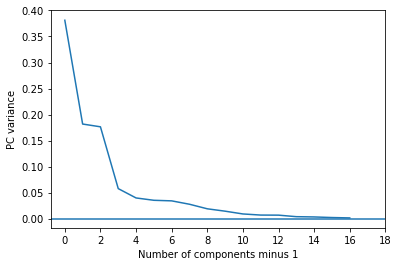

In [21]:
pca = PCA(n_components = .999, svd_solver = 'full')
pca.fit(X_trntst)
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Number of components minus 1')
plt.ylabel('PC variance')
plt.xticks(np.arange(0, len(X_trntst.columns), step=2))
plt.axhline(y=0,xmin=0,xmax=len(X_trntst.columns))
X_trntst = X_trntst_save.copy()

In [22]:
# We look at the above picture, select how many PCs we want to keep, and then redo the PCA with just this many PCs
pca = PCA(n_components = 4, svd_solver = 'full')
princ_comps = pca.fit_transform(X_trntst)
X_trntst_pca = pd.DataFrame(princ_comps, columns = ['PC' + str(i) for i in range(1, pca.n_components_+1)])
X_trntst_pca.head()

,PC1,PC2,PC3,PC4
0,-2.379442,-0.599588,-0.281669,-2.548869
1,-2.375675,-0.574965,-0.271029,-2.543657
2,-2.355746,-0.444701,-0.214742,-2.516085
3,-2.379442,-0.599588,-0.281669,-2.548869
4,1.189104,0.688353,-4.454551,-2.620904


In [23]:
princ_comps = pca.transform(X_oot)
X_oot_orig_pca = pd.DataFrame(princ_comps, columns = ['PC' + str(i) for i in range(1, pca.n_components_+1)],index=X_oot.index)
X_oot_orig_pca.head()

,PC1,PC2,PC3,PC4
85264,1.105279,-0.950573,0.118330,0.890316
85265,2.259955,0.488388,-4.457681,-1.582372
85266,-2.107495,1.730460,1.050826,-0.366579
85267,-0.732057,-0.461047,0.127960,0.608133
85268,-2.220142,-0.126191,0.455281,0.113203


In [24]:
X_trntst.describe()

,Cardnum_unique_count_for_card_state_1,Card_Merchdesc_State_total_7,Cardnum_count_1_by_30,Cardnum_max_14,Card_dow_vdratio_0by60,Card_dow_vdratio_0by14,Merchnum_desc_State_total_3,Card_Merchdesc_total_7,Card_dow_unique_count_for_merch_zip_7,Cardnum_actual/toal_0,Card_dow_vdratio_0by7,Cardnum_vdratio_1by7,Cardnum_unique_count_for_card_state_3,Cardnum_unique_count_for_card_zip_3,Merchnum_desc_Zip_total_3,Cardnum_unique_count_for_Merchnum_3,Cardnum_actual/toal_1,Cardnum_unique_count_for_card_state_7,Cardnum_actual/max_0,Card_dow_unique_count_for_merch_state_1
count,85264.000000,85264.000000,85264.000000,85264.000000,85264.000000,85264.000000,85264.000000,85264.000000,85264.000000,85264.000000,85264.000000,85264.000000,85264.000000,85264.000000,85264.000000,85264.000000,85264.000000,85264.000000,85264.000000,85264.000000
mean,0.004006,0.002794,-0.013411,0.003866,0.000122,0.003494,0.011369,0.002805,0.004227,-0.007076,0.004760,-0.000502,0.006726,0.005786,0.011402,0.005656,-0.009701,0.006369,-0.000725,0.003383
std,1.007299,1.029148,0.996083,0.988241,0.999618,1.000623,1.038863,1.029151,1.014974,1.003383,1.000962,0.995805,1.007166,1.006367,1.038809,1.006149,1.001578,1.009276,1.000119,1.013853
min,-0.465180,-0.334628,-1.044444,-0.719426,-0.645300,-0.759504,-0.431853,-0.334696,-0.503195,-2.156969,-0.803986,-1.010804,-0.608947,-0.554969,-0.431636,-0.565726,-1.589062,-0.806676,-3.006156,-0.324849
25%,-0.465180,-0.307403,-0.680554,-0.528478,-0.616386,-0.699287,-0.400153,-0.307467,-0.503195,-0.748928,-0.737477,-0.786234,-0.608947,-0.554969,-0.399955,-0.565726,-1.087599,-0.806676,0.451857,-0.324849
50%,-0.465180,-0.234920,-0.390242,-0.220376,-0.572577,-0.640374,-0.318782,-0.234966,-0.503195,0.659152,-0.652612,-0.446487,-0.088381,-0.195242,-0.318624,-0.218050,0.421275,-0.405464,0.451857,-0.324849
75%,0.178299,-0.019391,0.273329,0.354082,0.306509,0.831346,-0.004259,-0.019273,0.066968,0.659152,1.027719,0.686001,0.432185,0.164486,-0.003929,0.129626,0.935020,0.396962,0.451857,-0.324849
max,10.094246,21.831881,2.927610,11.363510,2.689572,1.892914,16.387194,21.831284,10.690830,0.659152,1.638749,2.384733,10.002362,10.226143,16.406502,10.240323,0.935020,8.822426,0.451857,11.536596


In [25]:
X_oot_orig_pca.describe()

,PC1,PC2,PC3,PC4
count,12232.000000,12232.000000,12232.000000,12232.000000
mean,-0.139962,-0.080014,-0.074155,-0.096704
std,2.703259,1.454299,1.763518,1.083973
min,-2.525181,-7.156347,-5.583494,-5.793721
25%,-2.193443,-0.695764,-0.617556,-0.544997
50%,-1.189225,-0.390531,0.242040,0.046608
75%,1.472658,0.274310,0.769220,0.463284
max,22.038502,36.498950,12.491464,6.578614


In [26]:
# zscale the PCs
mean = X_trntst_pca.mean()
stdev = X_trntst_pca.std()
X_trntst_pca = (X_trntst_pca - mean)/stdev
X_oot_orig_pca = (X_oot_orig_pca - mean)/stdev

In [27]:
X_trntst_pca.describe()

,PC1,PC2,PC3,PC4
count,8.526400e+04,8.526400e+04,8.526400e+04,8.526400e+04
mean,1.066681e-17,1.083348e-17,-7.333430e-18,2.266697e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-9.196246e-01,-3.971647e+00,-2.953876e+00,-6.037210e+00
25%,-7.542822e-01,-3.626125e-01,-3.988543e-01,-3.830293e-01
50%,-3.285056e-01,-1.858258e-01,1.436538e-01,1.262343e-01
75%,5.405079e-01,1.635085e-01,4.700401e-01,5.400949e-01
max,8.425471e+00,1.989997e+01,8.840546e+00,6.291476e+00


In [28]:
X_oot_orig_pca.describe()

,PC1,PC2,PC3,PC4
count,12232.000000,12232.000000,12232.000000,12232.000000
mean,-0.050212,-0.041572,-0.039105,-0.089217
std,0.969797,0.755593,0.929989,1.000059
min,-0.905911,-3.718140,-2.944447,-5.345207
25%,-0.786900,-0.361490,-0.325667,-0.502806
50%,-0.426635,-0.202903,0.127639,0.043000
75%,0.528317,0.142520,0.405647,0.427419
max,7.906332,18.963335,6.587355,6.069339


In [29]:
X_trntst_pca.shape

(85264, 4)

In [30]:
X_oot_orig_pca.shape

(12232, 4)

## Subsample the larger class if desired

In [31]:
# set the ratio of goods to bads that you would like. This next line is the ratio of goods to bads that you want for modeling
sample_ratio_desired = 1

temp = X_trntst.copy()
temp['Fraud'] = Y_trntst['Fraud']
temp.head()
goods = temp[temp['Fraud']==0]
bads = temp[temp['Fraud']==1]
actual_bad_fraction = len(bads)/len(temp)
actual_good_fraction = 1 - actual_bad_fraction
print(actual_bad_fraction)
fraction = sample_ratio_desired * actual_bad_fraction
goods_sampled = goods.sample(frac = fraction)
all_sampled = pd.concat([goods_sampled,bads])
all_sampled.sort_index(inplace=True)
Y_trntst_sampled = pd.DataFrame(all_sampled['Fraud'])
X_trntst_sampled = all_sampled.drop(columns=['Fraud'])
del [temp,goods,bads,all_sampled]
gc.collect()
print(X_trntst_sampled.shape,len(Y_trntst_sampled))

0.020524488647025708
(3464, 20) 3464


In [32]:
niter = 0
nitermax = 10
jittersize = .1
X_oot_orig = X_oot.copy()
pd.options.mode.chained_assignment = None  # default='warn'

## Models

You can comment in/out any of these model cells and just explore one model type. You can also just rerun that single cell multiple times (hit shift-enter on that cell) as you manually explore different model hyperparameters.

In [33]:
Modeling_output = pd.DataFrame(columns=['Model','Trn','Tst','OOT'],index=range(1000))
counter = 0
model_counter = 0

In [34]:
# %%time
# # Logistic regression

# FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):    
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

#     model = LogisticRegression(penalty='elasticnet', C=1, solver='saga', l1_ratio=0.8)
 
#     X_oot = X_oot_orig.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*detect_rate))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*detect_rate))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*detect_rate))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['log reg',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR.mean())
# model_counter = model_counter + 1

In [35]:
%%time
# Single DT

FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = DecisionTreeClassifier(
        #criterion='gini',
        #splitter='best',  # or 'random'
        max_depth=8,  # or an integer value
        min_samples_split=120,  # or other integer based on the table
        min_samples_leaf=60  # or other integer based on the table
    )
 
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*detect_rate))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*detect_rate))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*detect_rate))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['DT',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
    counter = counter + 1

print(FDR.mean())
model_counter = model_counter + 1

0 0.7545526524148852 0.7186858316221766 0.5016835016835017
1 0.7609756097560976 0.7192307692307692 0.46464646464646464
2 0.7479608482871125 0.7385496183206107 0.45791245791245794
3 0.7579462102689487 0.6998087954110899 0.49158249158249157
4 0.7441485068603713 0.7377690802348337 0.468013468013468
5 0.7473853580048271 0.7120315581854043 0.4781144781144781
6 0.7557312252964427 0.7072164948453609 0.4781144781144781
7 0.7463414634146341 0.725 0.4983164983164983
8 0.7458432304038005 0.7453798767967146 0.4882154882154882
9 0.760459392945037 0.7024482109227872 0.46464646464646464
trn    0.752134
tst    0.720612
oot    0.479125
dtype: float64
CPU times: user 4.96 s, sys: 0 ns, total: 4.96 s
Wall time: 4.95 s


In [36]:
%%time
# RF

FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

# Note for students: The default values are a fairly complex architecture and make this cell run slow.
    model = RandomForestClassifier(
        n_estimators=30,
        #criterion='gini',
        max_depth=20,
        min_samples_split=120,
        min_samples_leaf=60,
        max_features=7
    )
    
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*detect_rate))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*detect_rate))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*detect_rate))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['RF',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR.mean())
model_counter = model_counter + 1

0 0.7707160096540627 0.7850098619329389 0.5353535353535354
1 0.7864710676446618 0.7361376673040153 0.5420875420875421
2 0.7955482275350371 0.7337057728119181 0.5016835016835017
3 0.7893422148209825 0.761384335154827 0.5858585858585859
4 0.7794238683127572 0.7663551401869159 0.5757575757575758
5 0.7801131770412287 0.7758284600389863 0.5723905723905723
6 0.7952105697770437 0.7532467532467533 0.5185185185185185
7 0.7754271765663141 0.761996161228407 0.5824915824915825
8 0.778496362166532 0.7699805068226121 0.5723905723905723
9 0.7841004184100419 0.7675675675675676 0.5892255892255892
trn    0.783485
tst    0.761121
oot    0.557576
dtype: float64
CPU times: user 1min 12s, sys: 0 ns, total: 1min 12s
Wall time: 1min 12s


In [37]:
%%time
# LGBM

FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = lgb.LGBMClassifier(
        n_estimators=30,
        num_leaves = 4
        #criterion='gini',
        #max_depth=20,
#         min_samples_split=1000,
#         min_samples_leaf=100
    )

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*detect_rate))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter,'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*detect_rate))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter,'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*detect_rate))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter,'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['LGBM',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR.mean())
model_counter = model_counter + 1

[LightGBM] [Info] Number of positive: 1247, number of negative: 58437
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002366 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3466
[LightGBM] [Info] Number of data points in the train set: 59684, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020893 -> initscore=-3.847209
[LightGBM] [Info] Start training from score -3.847209
0 0.756214915797915 0.7614314115308151 0.5050505050505051
[LightGBM] [Info] Number of positive: 1218, number of negative: 58466
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001057 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3466
[LightGBM] [Info] Number of data points in the train set: 59684, number of used features: 20
[LightGBM] [Info] [binary:

In [38]:
# %%time
# # LGBM with SMOTE
# from imblearn.over_sampling import SMOTE

# FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):    
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)
    
#     sm = SMOTE()
    
#     X_trn_sm, Y_trn_sm = sm.fit_resample(X_trn,Y_trn)
    
#     print(niter, X_trn.shape,Y_trn.shape)
#     print(niter, X_trn_sm.shape,Y_trn_sm.shape)
#     print(Y_trn.sum())
#     print(Y_trn_sm.sum())

#     model = lgb.LGBMClassifier()

#     X_oot = X_oot_orig.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn_sm, Y_trn_sm.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*detect_rate))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter,'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*detect_rate))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter,'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*detect_rate))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter,'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['LGBM with SMOTE',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR.mean())
# model_counter = model_counter + 1

In [39]:
# %%time
# # LGBM with jitter

# jittersize = .1
# FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):    
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)
    
#     print(niter, X_trn.shape,Y_trn.shape)
    
#     X_trn_bads = X_trn[Y_trn == 1]
#     Y_trn_bads = Y_trn[Y_trn == 1]
    
#     print(X_trn_bads.head())
#     for i in range(2):
#         X_trn_more = X_trn_bads*(1+jittersize*random.uniform(-1,1))
#         X_trn = X_trn.append(X_trn_more,ignore_index=True)
#         Y_trn = Y_trn.append(Y_trn_bads,ignore_index=True)
        
#     print(niter, X_trn.shape,Y_trn.shape)

#     model = lgb.LGBMClassifier()

#     X_oot = X_oot_orig.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*detect_rate))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter,'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*detect_rate))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter,'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*detect_rate))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter,'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['LGBM with jitter',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR.mean())
# model_counter = model_counter + 1

In [40]:
%%time
# NN

FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)
    
# Note for students: The default values are a fairly complex architecture and make this cell run slow.
    model = MLPClassifier(
        hidden_layer_sizes=(20,20),
        #activation='relu',
        alpha=0.005,
        #learning_rate='constant',
        learning_rate_init=0.01,
        #max_iter=50
    )
    
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*detect_rate))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*detect_rate))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*detect_rate))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['NN',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR.mean())
model_counter = model_counter + 1

0 0.8213689482470785 0.7554347826086957 0.569023569023569
1 0.8050778050778051 0.7504725897920604 0.5252525252525253
2 0.8287337662337663 0.777992277992278 0.5824915824915825
3 0.8060897435897436 0.7928286852589641 0.5858585858585859
4 0.8336079077429983 0.7985074626865671 0.5993265993265994
5 0.8271103896103896 0.7895752895752896 0.5757575757575758
6 0.8073770491803278 0.7660377358490567 0.5892255892255892
7 0.8117744610281924 0.7830882352941176 0.5723905723905723
8 0.8333333333333334 0.7724137931034483 0.5858585858585859
9 0.8006535947712419 0.7699619771863118 0.5757575757575758
trn    0.817513
tst    0.775631
oot    0.576094
dtype: float64
CPU times: user 1min 48s, sys: 40.9 s, total: 2min 29s
Wall time: 1min 26s


In [41]:
# %%time
# # NN on pc's

# FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst_pca, Y_trntst, test_size = .3)

#     model = MLPClassifier(hidden_layer_sizes=(10,10),alpha=.005,solver='adam',activation='relu',
#                           max_iter=1000,learning_rate='adaptive',learning_rate_init=.01)

#     X_oot = X_oot_orig_pca.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*detect_rate))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*detect_rate))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*detect_rate))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['NN_PCs',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR.mean())
# model_counter = model_counter + 1

In [42]:
# %%time
# # GBC

# FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

#     model = GradientBoostingClassifier(learning_rate=0.01,max_depth=4,n_estimators=300)

#     X_oot = X_oot_orig.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*detect_rate))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*detect_rate))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*detect_rate))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['GBC',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR.mean())
# model_counter = model_counter + 1

In [43]:
%%time
# Catboost

FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = CatBoostClassifier(
        verbose=0,
        depth=3,
        learning_rate=0.02,  # Ensure this is set correctly
        l2_leaf_reg=6,
        min_data_in_leaf=100
    )

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*detect_rate))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*detect_rate))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*detect_rate))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['cat boost',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR.mean())
model_counter = model_counter + 1

0 0.7808 0.758 0.5353535353535354
1 0.7905460472697636 0.7667304015296367 0.5521885521885522
2 0.7922624053826746 0.7629233511586453 0.5218855218855218
3 0.7822514379622021 0.7823639774859287 0.5185185185185185
4 0.7824675324675324 0.7741312741312741 0.4781144781144781
5 0.7723970944309927 0.8023483365949119 0.5084175084175084
6 0.7899090157154673 0.722735674676525 0.5084175084175084
7 0.788961038961039 0.7586872586872587 0.531986531986532
8 0.7845394736842105 0.7790262172284644 0.5151515151515151
9 0.7859450726978998 0.755859375 0.4983164983164983
trn    0.785008
tst    0.766281
oot    0.516835
dtype: float64
CPU times: user 4min 22s, sys: 16.9 s, total: 4min 39s
Wall time: 36.5 s


In [44]:
# %%time
# # NOTE this cell has been substantially modified to evaluate a sampled trn/tst data set. 
# # Only use this cell if you do downsampling of the goods.
# # each good needs to have a weight of (1-actual_ratio)/sample_ratio_desired
# # it's hard to get the correct FDR@3% for the actual train and test, so I just use the original trntst after the model is built for evaluation

# xmult = actual_good_fraction / (actual_bad_fraction * sample_ratio_desired)
# print(xmult)
# FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst_sampled, Y_trntst_sampled, test_size = .3)

#     model = lgb.LGBMClassifier(n_estimators=50,
#         criterion=gini,
#         max_depth=None,
#         min_samples_split=2,
#         min_samples_leaf=1)

#     model.fit(X_trn, Y_trn.values.ravel())  
    
#     X_oot = X_oot_orig.copy()
#     X_trn = X_trntst.copy()
#     Y_trn = Y_trntst.copy()
#     X_tst = X_trntst.copy()
#     Y_tst = Y_trntst.copy()

#     predictions = model.predict_proba(X_trntst)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trntst['Fraud']
#     topRows = int(round(X_trn.shape[0]*detect_rate))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_trntst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_trntst['Fraud']
#     topRows = int(round(X_tst.shape[0]*detect_rate))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*detect_rate))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['LGBM sampled',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR.mean())
# model_counter = model_counter + 1

In [45]:
# %%time
# # Catboost on pc's

# FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst_pca, Y_trntst, test_size = .3)

#     model = CatBoostClassifier(verbose=0, iterations=100)
# #             learning_rate=detect_rate,
# #             l2_leaf_reg=5  
# #

#     X_oot = X_oot_orig_pca.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*detect_rate))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*detect_rate))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*detect_rate))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['cat boost_PCs',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR.mean())
# model_counter = model_counter + 1

In [46]:
# %%time
# # unsupervised model using pc's. 

# FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst_pca, Y_trntst, test_size = .3)

#     X_oot = X_oot_orig_pca.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     pow = 2
#     oop = 1/pow
#     predictions = ((X_trn.abs()**pow).sum(axis=1))**oop
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*detect_rate))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = ((X_tst.abs()**pow).sum(axis=1))**oop
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*detect_rate))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = ((X_oot.abs()**pow).sum(axis=1))**oop
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*detect_rate))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['unsupervised outliers',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR.mean())
# model_counter = model_counter + 1

In [47]:
%%time
# XGB

FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

#     model = xgb.XGBClassifier(booster='gbtree',max_depth=4,min_child_weight=75,gamma=0.01)
    model = xgb.XGBClassifier(booster='gbtree',n_estimators=100,max_depth=3,learning_rate=.1)

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*detect_rate))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*detect_rate))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*detect_rate))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['XGB',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR.mean())
model_counter = model_counter + 1

0 0.8058091286307054 0.7834862385321101 0.5454545454545454
1 0.8115477145148356 0.7872763419483101 0.5555555555555556
2 0.8244336569579288 0.7859922178988327 0.5488215488215489
3 0.8127090301003345 0.7653429602888087 0.5016835016835017
4 0.8137254901960784 0.7870722433460076 0.5420875420875421
5 0.8098360655737705 0.8 0.5723905723905723
6 0.8196457326892109 0.7874015748031497 0.5084175084175084
7 0.8087027914614121 0.7857142857142857 0.5353535353535354
8 0.8054635761589404 0.8025830258302583 0.5117845117845118
9 0.8237232289950577 0.753731343283582 0.5016835016835017
trn    0.813560
tst    0.783860
oot    0.532323
dtype: float64
CPU times: user 14 s, sys: 43.8 ms, total: 14.1 s
Wall time: 2.13 s


In [48]:
# %%time
# # Knn
# # Knn can be very slow with a lot of records.

# FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)
#     model = KNeighborsClassifier(n_neighbors=80) 
    
#     X_oot = X_oot_orig.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*detect_rate))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*detect_rate))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*detect_rate))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['Knn',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR.mean())
# model_counter = model_counter + 1

In [49]:
# %%time
# # SVM
# # SVM can be very slow. It scales like the # training records cubed

# FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

#     model = svm.SVC(kernel='poly',probability=True)
    
#     X_oot = X_oot_orig.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*detect_rate))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*detect_rate))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*detect_rate))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['SVM',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR.mean())
# model_counter = model_counter + 1

## Model comparison plots

In [50]:
df = Modeling_output.dropna()
df.head(20)

,Model,Trn,Tst,OOT
0,DT,0.754553,0.718686,0.501684
1,DT,0.760976,0.719231,0.464646
2,DT,0.747961,0.73855,0.457912
3,DT,0.757946,0.699809,0.491582
4,DT,0.744149,0.737769,0.468013
5,DT,0.747385,0.712032,0.478114
6,DT,0.755731,0.707216,0.478114
7,DT,0.746341,0.725,0.498316
8,DT,0.745843,0.74538,0.488215
9,DT,0.760459,0.702448,0.464646


In [51]:
df.shape

(60, 4)

In [52]:
df_unpivot = df.melt(id_vars='Model', value_vars=['Trn', 'Tst', 'OOT'], var_name='Type', value_name='Value')
df_unpivot.head()

,Model,Type,Value
0,DT,Trn,0.754553
1,DT,Trn,0.760976
2,DT,Trn,0.747961
3,DT,Trn,0.757946
4,DT,Trn,0.744149


In [53]:
df_compare = df_unpivot[(df_unpivot['Type']=='Trn') | (df_unpivot['Type']=='Tst') | (df_unpivot['Type']=='OOT')]
df_compare.head()

,Model,Type,Value
0,DT,Trn,0.754553
1,DT,Trn,0.760976
2,DT,Trn,0.747961
3,DT,Trn,0.757946
4,DT,Trn,0.744149


In [54]:
output = df.groupby('Model').agg({'Trn':['mean','std'],'Tst':['mean','std'],'OOT':['mean','std']})
output

Trn                 Tst                 OOT          
               mean       std      mean       std      mean       std
Model                                                                
DT         0.752134  0.006471  0.720612  0.015882  0.479125  0.015311
LGBM       0.754754  0.009094  0.747408  0.016260  0.531313  0.026550
NN         0.817513  0.012681  0.775631  0.015812  0.576094  0.019979
RF         0.783485  0.008215  0.761121  0.016238  0.557576  0.030867
XGB         0.81356  0.006884   0.78386  0.014546  0.532323  0.024867
cat boost  0.785008  0.005915  0.766281  0.020886  0.516835  0.020649

In [55]:
df.head()

,Model,Trn,Tst,OOT
0,DT,0.754553,0.718686,0.501684
1,DT,0.760976,0.719231,0.464646
2,DT,0.747961,0.73855,0.457912
3,DT,0.757946,0.699809,0.491582
4,DT,0.744149,0.737769,0.468013


In [56]:
best_OOT = df['OOT'].max()
best_OOT

0.5993265993265994

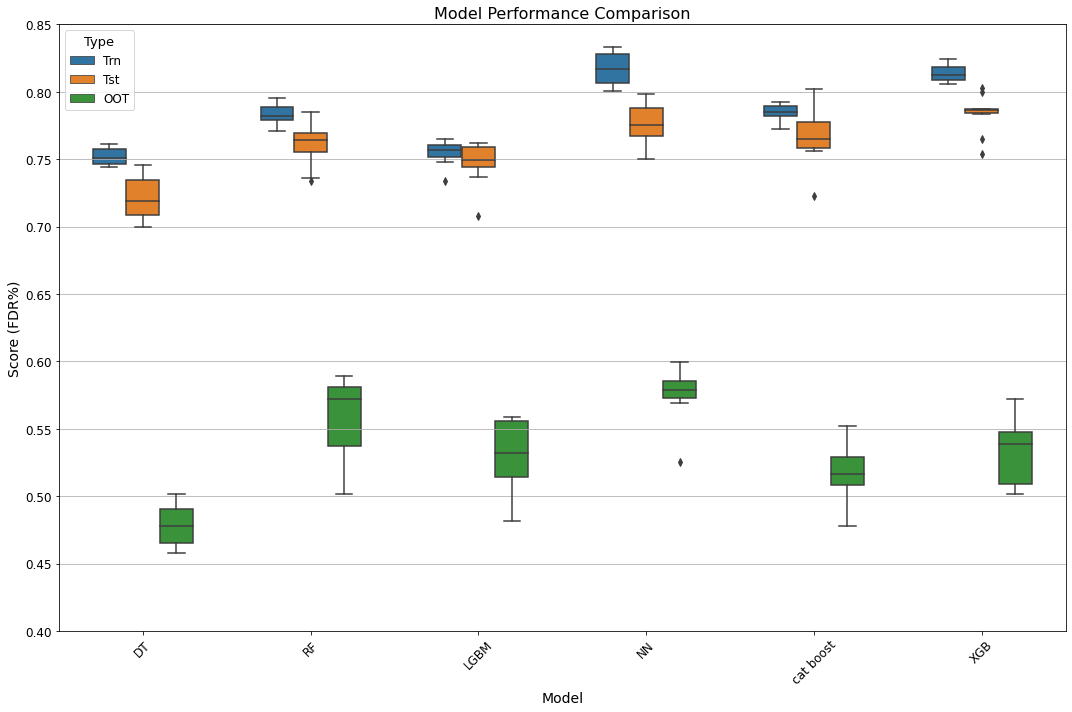

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))  # Adjust figure size as needed
ax = sns.boxplot(
    x='Model',
    y='Value',
    hue='Type',
    data=df_compare,
    palette='tab10',  # This uses a predefined palette that's well-differentiated
    width=0.6  # Adjust the width of the boxes to prevent overlap
)

# Set the limits of the y-axis to improve spacing
plt.ylim(0.4, 0.85)

# Enhancing the font sizes for better readability
plt.xlabel('Model', fontsize=14)
plt.ylabel('Score (FDR%)', fontsize=14)
plt.title('Model Performance Comparison', fontsize=16)

plt.xticks(rotation=45, fontsize=12)  # Rotate x labels for better legibility
plt.yticks(fontsize=12)
plt.legend(title='Type', fontsize=12, title_fontsize='13')  # Adjust legend

plt.grid(axis='y')  # Add gridlines

plt.tight_layout()  # Adjust subplot parameters to give some padding
plt.savefig('modeling.png')
plt.show()


In [58]:
print('duration: ', datetime.now() - start_time)

duration:  0:03:28.579601


This next cell can be used to explore overfitting

[LightGBM] [Info] Number of positive: 1246, number of negative: 58438
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000777 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3459
[LightGBM] [Info] Number of data points in the train set: 59684, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020877 -> initscore=-3.848028
[LightGBM] [Info] Start training from score -3.848028
0 0.723916532905297 0.7003968253968254 0.4882154882154882
[LightGBM] [Info] Number of positive: 1244, number of negative: 58440
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003016 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3468
[LightGBM] [Info] Number of data points in the train set: 59684, number of used features: 20
[LightGBM] [Info] [binary:

1 0.8554621848739495 0.7892857142857143 0.5488215488215489
[LightGBM] [Info] Number of positive: 1199, number of negative: 58485
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000622 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3468
[LightGBM] [Info] Number of data points in the train set: 59684, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020089 -> initscore=-3.887282
[LightGBM] [Info] Start training from score -3.887282
2 0.8673894912427023 0.79491833030853 0.531986531986532
loop trn tst oot 6 0.8571768730903918 0.7995251006930914 0.5488215488215489
[LightGBM] [Info] Number of positive: 1191, number of negative: 58493
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000806 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not

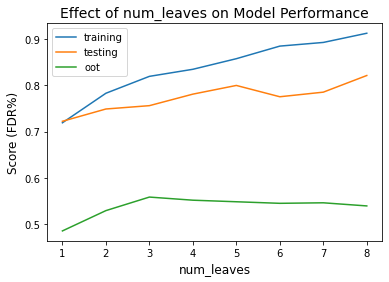

CPU times: user 1min 4s, sys: 230 ms, total: 1min 4s
Wall time: 9.61 s


In [79]:
%%time
nitermax2 = 3
training = []
testing = []
oot = []
results = pd.DataFrame(np.zeros((niter,3)),columns=['trn','tst','oot'])
for i in range(2,10,1):
    for niter in range(nitermax2):
        X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)
        
        model = lgb.LGBMClassifier(
        n_estimators=200,
        num_leaves = i
        )

        model.fit(X_trn, Y_trn.values.ravel()) 

        X_oot = X_oot_orig.copy()
        X_trn_save = X_trn.copy()
        Y_trn_save = Y_trn.copy()
    
        predictions = model.predict_proba(X_trn_save)[:,1]
        X_trn['predicted'] = predictions
        X_trn['Fraud'] = Y_trn_save['Fraud']
        topRows = int(round(X_trn.shape[0]*detect_rate))
        temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        results.loc[niter,'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

        predictions = model.predict_proba(X_tst)[:,1]
        X_tst['predicted']=predictions
        X_tst['Fraud'] = Y_tst['Fraud']
        topRows = int(round(X_tst.shape[0]*detect_rate))
        temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        results.loc[niter,'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

        predictions = model.predict_proba(X_oot)[:,1]
        X_oot['predicted']=predictions
        X_oot['Fraud'] = Y_oot['Fraud']
        topRows = int(round(X_oot.shape[0]*detect_rate))
        temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        results.loc[niter,'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
        print(niter, results.loc[niter,'trn'],results.loc[niter,'tst'],results.loc[niter,'oot'],)

    results_mean_trn = results['trn'].mean()
    results_mean_tst = results['tst'].mean()
    results_mean_oot = results['oot'].mean()
    print('loop', 'trn', 'tst', 'oot', i, results_mean_trn, results_mean_tst, results_mean_oot)
    training.append(results_mean_trn)
    testing.append(results_mean_tst)
    oot.append(results_mean_oot)

table=pd.DataFrame({'n': range(1,len(training)+1),'training':training,'testing':testing,'oot':oot})
table.set_index('n',inplace=True) 
table.plot()
plt.xlabel('num_leaves', fontsize=12)
plt.ylabel('Score (FDR%)', fontsize=12)
plt.title('Effect of num_leaves on Model Performance', fontsize=14)
#plt.savefig('complexity_NN.pdf', format='pdf')
plt.show()

In [60]:
best_OOT

0.5993265993265994

The rest of the notebook makes the tables for your final model of choice. You need to run that final model only once (no CV). If you want you can run the below cell over and over by itself until it gives you a model you like (due to the stochastic nature of some ML algorithms, but you can't change from your best hyperparameters.

In [76]:
%%time
# Note - need to set this next value to around the highest oot fdr for your model of choice.
# The model then runs a nombermof times with your fixed hyperparameters until it finds a good model.
desire = .59
print('desire =', desire)
for niter in range(50):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

# here's where you put your final model of choice
# I run this loop a large number of times with an unreasonably high stopping criterion (the break condition)
# I then look at all these runs and select a value of the oot performance where I want to break out this loop
# and that will be my final model run of choice

    model = lgb.LGBMClassifier(
        n_estimators=200,
        num_leaves = 4
        )
    
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*detect_rate))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*detect_rate))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*detect_rate))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['LGBM',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
    counter = counter + 1
# choose a good break point
    if(FDR.loc[niter, 'oot'] > desire): break
    
model_counter = model_counter + 1

desire = 0.59
[LightGBM] [Info] Number of positive: 1229, number of negative: 58455
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002646 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3470
[LightGBM] [Info] Number of data points in the train set: 59684, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020592 -> initscore=-3.862056
[LightGBM] [Info] Start training from score -3.862056
0 0.806346623270952 0.7715930902111324 0.5521885521885522
[LightGBM] [Info] Number of positive: 1220, number of negative: 58464
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000646 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3468
[LightGBM] [Info] Number of data points in the train set: 59684, number of used features: 20
[LightGBM] [

In [62]:
X_trn_eval = X_trn.copy()
X_tst_eval = X_tst.copy()
X_oot_eval = X_oot.copy()

In [63]:
cols = ['bin','#recs','#g','#b','%g','%b','tot','cg','cb','%cg','FDR','KS','FPR']
FDR_trn = pd.DataFrame(np.zeros((101, 13)), columns = cols)
FDR_tst = pd.DataFrame(np.zeros((101, 13)), columns = cols)
FDR_oot = pd.DataFrame(np.zeros((101, 13)), columns = cols)
trn_sorted = X_trn_eval.sort_values('predicted',ascending=False)
tst_sorted = X_tst_eval.sort_values('predicted',ascending=False)
oot_sorted = X_oot_eval.sort_values('predicted',ascending=False)
bad_tot_trn = sum(X_trn_eval.loc[:, 'Fraud'])
bad_tot_tst = sum(X_tst_eval.loc[:, 'Fraud'])
bad_tot_oot = sum(X_oot_eval.loc[:, 'Fraud'])
num_tot_trn = len(X_trn_eval)
num_tot_tst = len(X_tst_eval)
num_tot_oot = len(X_oot_eval)
good_tot_trn = num_tot_trn - bad_tot_trn
good_tot_tst = num_tot_tst - bad_tot_tst
good_tot_oot = num_tot_oot - bad_tot_oot
oot_sorted.head(20)

,Cardnum_unique_count_for_card_state_1,Card_Merchdesc_State_total_7,Cardnum_count_1_by_30,Cardnum_max_14,Card_dow_vdratio_0by60,Card_dow_vdratio_0by14,Merchnum_desc_State_total_3,Card_Merchdesc_total_7,Card_dow_unique_count_for_merch_zip_7,Cardnum_actual/toal_0,...,Cardnum_unique_count_for_card_state_3,Cardnum_unique_count_for_card_zip_3,Merchnum_desc_Zip_total_3,Cardnum_unique_count_for_Merchnum_3,Cardnum_actual/toal_1,Cardnum_unique_count_for_card_state_7,Cardnum_actual/max_0,Card_dow_unique_count_for_merch_state_1,predicted,Fraud
90933,7.256559,-0.046803,2.190310,-0.185289,2.493320,1.892914,-0.260007,-0.046880,7.479088,-1.774862,...,5.637844,5.920128,-0.259483,5.692441,-1.325927,4.007875,-0.877403,10.287893,0.990481,1
94031,7.900037,-0.324574,1.047494,-0.114619,1.512059,1.671754,-0.425850,-0.324642,5.198436,-2.142262,...,6.158410,5.560400,-0.425622,5.692441,-1.579579,4.409088,-2.940496,7.255681,0.980239,1
88021,5.326124,0.029211,1.479820,-0.266383,2.432935,1.688766,-0.214622,0.029132,5.198436,-1.344831,...,4.076147,3.761762,-0.214017,3.606385,-0.886161,3.205450,0.166403,7.255681,0.978587,1
94135,7.256559,-0.082879,0.557716,-0.114619,2.212960,1.892914,-0.281546,-0.082955,2.347620,-1.374680,...,7.199542,7.359038,-0.281060,7.778496,-1.364339,5.211513,-0.433736,3.465416,0.977696,1
93866,4.682646,0.086734,0.671471,-0.122573,0.869779,1.450594,-0.180278,0.086652,1.777457,-1.044678,...,3.555581,3.402034,-0.179612,3.606385,-1.002588,2.403025,-0.217180,2.707363,0.976888,1
96243,7.900037,-0.322862,2.330397,-0.188352,2.689572,1.892914,-0.424828,-0.322929,5.198436,-2.137171,...,6.158410,5.560400,-0.424598,5.344765,-1.575458,4.409088,-2.918637,7.255681,0.973769,1
90115,-0.465180,12.690366,2.774478,1.493632,2.689572,1.892914,7.344743,12.689867,-0.503195,-1.493364,...,-0.608947,-0.554969,7.358863,-0.565726,-1.449263,-0.806676,-0.303934,-0.324849,0.972978,1
95997,4.039168,-0.113518,2.008820,-0.380382,2.689572,1.892914,-0.299839,-0.113593,1.207294,-1.345079,...,3.035015,3.042307,-0.299386,2.911033,-1.151123,2.001812,-0.248524,1.949310,0.972401,0
96225,7.256559,0.130242,2.298964,-0.188352,2.689572,1.892914,0.837749,0.130159,4.628273,-1.368060,...,5.637844,5.200672,0.840236,4.997089,-1.047553,4.007875,0.451857,6.497628,0.971630,1
90973,7.256559,-0.328159,2.264040,-0.185289,2.522758,1.892914,-0.427990,-0.328227,8.619415,-2.149524,...,5.637844,6.639583,-0.427767,6.387792,-1.583783,4.007875,-2.958319,11.536596,0.971222,1


In [64]:
cost_fraud = 1000
cost_fp = 30
for i in range(101):
    percent_rows_trn = int(round(X_trn_eval.shape[0]*0.01*i))
    percent_rows_tst = int(round(X_tst_eval.shape[0]*0.01*i))
    percent_rows_oot = int(round(X_oot_eval.shape[0]*0.01*i))
    temp_trn = trn_sorted.head(percent_rows_trn)
    temp_tst = tst_sorted.head(percent_rows_tst)
    temp_oot = oot_sorted.head(percent_rows_oot)
    num_bad_trn = sum(temp_trn.loc[:,'Fraud'])
    num_bad_tst = sum(temp_tst.loc[:,'Fraud'])
    num_bad_oot = sum(temp_oot.loc[:,'Fraud'])
    num_tot_trn = len(temp_trn)
    num_tot_tst = len(temp_tst)
    num_tot_oot = len(temp_oot)
    num_good_trn = num_tot_trn - num_bad_trn
    num_good_tst = num_tot_tst - num_bad_tst
    num_good_oot = num_tot_oot - num_bad_oot
    
    FDR_trn.loc[i, 'bin'] = i
    FDR_trn.loc[i,'#recs'] = 0
    FDR_trn.loc[i, 'tot'] = num_tot_trn
    FDR_trn.loc[i, 'cg'] = num_good_trn
    FDR_trn.loc[i, 'cb'] = num_bad_trn
    FDR_trn.loc[i, 'Fraud Savings'] = FDR_trn.loc[i, 'cb'] * cost_fraud
    FDR_trn.loc[i, 'FP Loss'] = FDR_trn.loc[i, 'cg'] * cost_fp
    FDR_trn.loc[i, 'Overall Savings'] = FDR_trn.loc[i, 'Fraud Savings'] - FDR_trn.loc[i, 'FP Loss']
    FDR_tst.loc[i, 'bin'] = i
    FDR_tst.loc[i, 'tot'] = num_tot_tst
    FDR_tst.loc[i, 'cg'] = num_good_tst
    FDR_tst.loc[i, 'cb'] = num_bad_tst
    FDR_tst.loc[i, 'Fraud Savings'] = FDR_tst.loc[i, 'cb'] * cost_fraud
    FDR_tst.loc[i, 'FP Loss'] = FDR_tst.loc[i, 'cg'] * cost_fp
    FDR_tst.loc[i, 'Overall Savings'] = FDR_tst.loc[i, 'Fraud Savings'] - FDR_tst.loc[i, 'FP Loss']
    FDR_oot.loc[i, 'bin'] = i
    FDR_oot.loc[i, 'tot'] = num_tot_oot
    FDR_oot.loc[i, 'cg'] = num_good_oot
    FDR_oot.loc[i, 'cb'] = num_bad_oot

    if i != 0:
        FDR_trn.loc[i, '#g'] = num_good_trn - FDR_trn.loc[i-1, 'cg']
        FDR_trn.loc[i, '#b'] = num_bad_trn - FDR_trn.loc[i-1, 'cb']
        FDR_trn.loc[i,'#recs'] = FDR_trn.loc[i, '#g'] + FDR_trn.loc[i, '#b']
        FDR_trn.loc[i, '%g'] = 100* (num_good_trn - FDR_trn.loc[i-1, 'cg']) / (num_tot_trn - FDR_trn.loc[i-1, 'tot'])
        FDR_trn.loc[i, '%b'] = 100 - FDR_trn.loc[i, '%g']
        FDR_trn.loc[i, '%cg'] = 100 * num_good_trn / good_tot_trn
        FDR_trn.loc[i, 'FDR'] = 100 * num_bad_trn / bad_tot_trn
        FDR_trn.loc[i, 'KS'] = FDR_trn.loc[i, 'FDR'] - FDR_trn.loc[i, '%cg']
        FDR_trn.loc[i, 'FPR'] = num_good_trn / num_bad_trn
        FDR_tst.loc[i, '#g'] = num_good_tst - FDR_tst.loc[i-1, 'cg']
        FDR_tst.loc[i, '#b'] = num_bad_tst - FDR_tst.loc[i-1, 'cb']
        FDR_tst.loc[i,'#recs'] = FDR_tst.loc[i, '#g'] + FDR_tst.loc[i, '#b']
        FDR_tst.loc[i, '%g'] = 100* (num_good_tst - FDR_tst.loc[i-1, 'cg']) / (num_tot_tst - FDR_tst.loc[i-1, 'tot'])
        FDR_tst.loc[i, '%b'] = 100 - FDR_tst.loc[i, '%g']
        FDR_tst.loc[i, '%cg'] = 100 * num_good_tst / good_tot_tst
        FDR_tst.loc[i, 'FDR'] = 100 * num_bad_tst / bad_tot_tst
        FDR_tst.loc[i, 'KS'] = FDR_tst.loc[i, 'FDR'] - FDR_tst.loc[i, '%cg']
        FDR_tst.loc[i, 'FPR'] = num_good_tst / num_bad_tst
        FDR_oot.loc[i, '#g'] = num_good_oot - FDR_oot.loc[i-1, 'cg']
        FDR_oot.loc[i, '#b'] = num_bad_oot - FDR_oot.loc[i-1, 'cb']
        FDR_oot.loc[i,'#recs'] = FDR_oot.loc[i, '#g'] + FDR_oot.loc[i, '#b']
        FDR_oot.loc[i, '%g'] = 100* (num_good_oot - FDR_oot.loc[i-1, 'cg']) / (num_tot_oot - FDR_oot.loc[i-1, 'tot'])
        FDR_oot.loc[i, '%b'] = 100 - FDR_oot.loc[i, '%g']
        FDR_oot.loc[i, '%cg'] = 100 * num_good_oot / good_tot_oot
        FDR_oot.loc[i, 'FDR'] = 100 * num_bad_oot / bad_tot_oot
        FDR_oot.loc[i, 'KS'] = FDR_oot.loc[i, 'FDR'] - FDR_oot.loc[i, '%cg']
        FDR_oot.loc[i, 'FPR'] = num_good_oot / num_bad_oot

FDR_oot

,bin,#recs,#g,#b,%g,%b,tot,cg,cb,%cg,FDR,KS,FPR
0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
1,1.0,122.0,22.0,100.0,18.032787,81.967213,122.0,22.0,100.0,0.184332,33.670034,33.485702,0.220000
2,2.0,123.0,75.0,48.0,60.975610,39.024390,245.0,97.0,148.0,0.812736,49.831650,49.018914,0.655405
3,3.0,122.0,96.0,26.0,78.688525,21.311475,367.0,193.0,174.0,1.617093,58.585859,56.968766,1.109195
4,4.0,122.0,110.0,12.0,90.163934,9.836066,489.0,303.0,186.0,2.538752,62.626263,60.087511,1.629032
...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,96.0,123.0,123.0,0.0,100.000000,0.000000,11743.0,11446.0,297.0,95.902807,100.000000,4.097193,38.538721
97,97.0,122.0,122.0,0.0,100.000000,0.000000,11865.0,11568.0,297.0,96.925010,100.000000,3.074990,38.949495
98,98.0,122.0,122.0,0.0,100.000000,0.000000,11987.0,11690.0,297.0,97.947214,100.000000,2.052786,39.360269
99,99.0,123.0,123.0,0.0,100.000000,0.000000,12110.0,11813.0,297.0,98.977796,100.000000,1.022204,39.774411


Max possible savings: 47,604,000.0


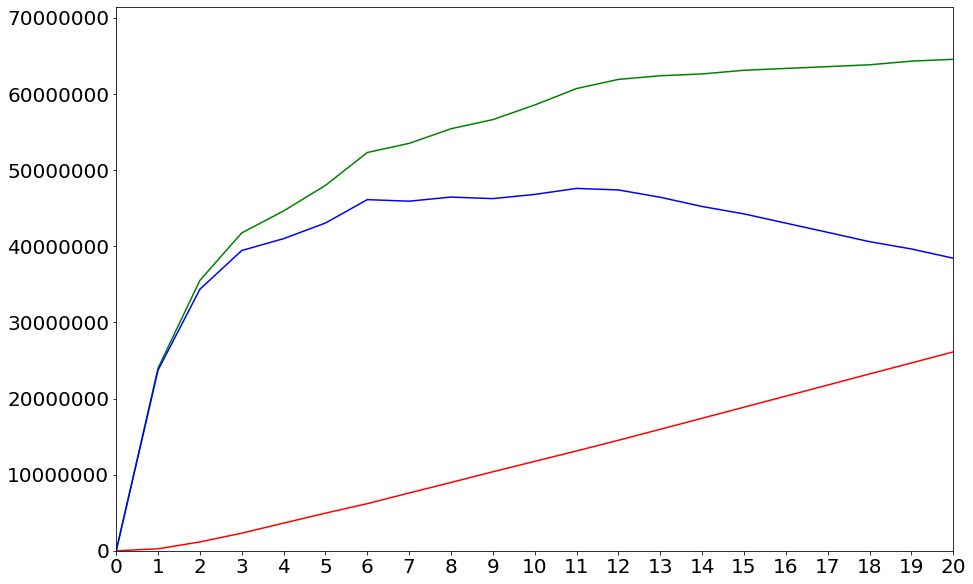

In [65]:
cost_fraud = 400
cost_fp = 20
# xmult: oot is only 2 out of 12 months. 100,000 sample transactions out of 10 million/year
xoot = 12/2 * 10000000/100000
Financials_trn = pd.DataFrame(np.zeros((101, 3)), columns = ['Fraud Savings','FP Loss','Overall Savings'])
Financials_tst = pd.DataFrame(np.zeros((101, 3)), columns = ['Fraud Savings','FP Loss','Overall Savings'])
Financials_oot = pd.DataFrame(np.zeros((101, 3)), columns = ['Fraud Savings','FP Loss','Overall Savings'])
for i in range(101):
    Financials_trn.loc[i, 'Fraud Savings'] = FDR_trn.loc[i, 'cb'] * cost_fraud * xoot
    Financials_trn.loc[i, 'FP Loss'] = FDR_trn.loc[i, 'cg'] * cost_fp * xoot
    Financials_trn.loc[i, 'Overall Savings'] = Financials_trn.loc[i, 'Fraud Savings'] - Financials_trn.loc[i, 'FP Loss']
    Financials_tst.loc[i, 'Fraud Savings'] = FDR_tst.loc[i, 'cb'] * cost_fraud * xoot
    Financials_tst.loc[i, 'FP Loss'] = FDR_tst.loc[i, 'cg'] * cost_fp * xoot
    Financials_tst.loc[i, 'Overall Savings'] = Financials_tst.loc[i, 'Fraud Savings'] - Financials_tst.loc[i, 'FP Loss']
    Financials_oot.loc[i, 'Fraud Savings'] = FDR_oot.loc[i, 'cb'] * cost_fraud * xoot
    Financials_oot.loc[i, 'FP Loss'] = FDR_oot.loc[i, 'cg'] * cost_fp * xoot
    Financials_oot.loc[i, 'Overall Savings'] = Financials_oot.loc[i, 'Fraud Savings'] - Financials_oot.loc[i, 'FP Loss']

max_savings = Financials_oot['Overall Savings'].max(0)
print('Max possible savings: '+'{:,}'.format(max_savings))
yupper = max_savings * 1.5
plt.rcParams.update({'font.size':20})
plt.figure(figsize=(15,10))
plt.plot(Financials_oot['Fraud Savings'], color='green')
plt.plot(Financials_oot['FP Loss'], color='red')
plt.plot(Financials_oot['Overall Savings'], color='blue')
xlimit = 20
interval = 1
plt.xlim(0,xlimit)
plt.ylim(0,yupper)
plt.xticks(ticks=np.linspace(0,xlimit, num=int(xlimit/interval)+1))
plt.ticklabel_format(style='plain')
plt.savefig('savings.png', format='png')

In [66]:
FDR_oot.head(10)

,bin,#recs,#g,#b,%g,%b,tot,cg,cb,%cg,FDR,KS,FPR
0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
1,1.0,122.0,22.0,100.0,18.032787,81.967213,122.0,22.0,100.0,0.184332,33.670034,33.485702,0.220000
2,2.0,123.0,75.0,48.0,60.975610,39.024390,245.0,97.0,148.0,0.812736,49.831650,49.018914,0.655405
3,3.0,122.0,96.0,26.0,78.688525,21.311475,367.0,193.0,174.0,1.617093,58.585859,56.968766,1.109195
4,4.0,122.0,110.0,12.0,90.163934,9.836066,489.0,303.0,186.0,2.538752,62.626263,60.087511,1.629032
5,5.0,123.0,109.0,14.0,88.617886,11.382114,612.0,412.0,200.0,3.452032,67.340067,63.888036,2.060000
6,6.0,122.0,104.0,18.0,85.245902,14.754098,734.0,516.0,218.0,4.323419,73.400673,69.077255,2.366972
7,7.0,122.0,117.0,5.0,95.901639,4.098361,856.0,633.0,223.0,5.303729,75.084175,69.780447,2.838565
8,8.0,123.0,115.0,8.0,93.495935,6.504065,979.0,748.0,231.0,6.267281,77.777778,71.510497,3.238095
9,9.0,122.0,117.0,5.0,95.901639,4.098361,1101.0,865.0,236.0,7.247591,79.461279,72.213688,3.665254


In [67]:
FDR.to_csv('FDR.csv')

In [68]:
FDR_trn.to_csv('FDR_trn.csv', index=False)
FDR_tst.to_csv('FDR_tst.csv', index=False)
FDR_oot.to_csv('FDR_oot.csv', index=False)

In [84]:
Metrics = FDR_trn.copy()
num_good = Metrics['#g'].sum()
num_bad = Metrics['#b'].sum()
num_tot = Metrics['#recs'].sum()
print(num_good,num_bad,num_good+num_bad,num_tot)

58463.0 1221.0 59684.0 59684.0


In [72]:
Metrics['TP'] = Metrics['cb']
Metrics['TN'] = num_good - Metrics['cg']
Metrics['FN'] = num_bad - Metrics['cb']
Metrics['FP'] = Metrics['cg']
Metrics['Accuracy'] = (Metrics['TP'] + Metrics['TN']) / num_tot
Metrics['Misclass'] = (Metrics['FP'] + Metrics['FN']) / num_tot
Metrics['FPRate'] = Metrics['FP'] / (Metrics['FP'] + Metrics['TN'])
Metrics['FPRatio'] = Metrics['FP'] / Metrics['TP']
Metrics['TPR'] = Metrics['TP'] / (Metrics['TP'] + Metrics['FN'])
Metrics['TNR'] = Metrics['TN'] / (Metrics['TN'] + Metrics['FP'])
Metrics['Precision'] = Metrics['TP'] / (Metrics['TP'] + Metrics['FP'])
Metrics['f1'] = 2 * Metrics['Precision'] * Metrics['TPR'] / (Metrics['Precision'] + Metrics['TPR'])
Metrics.to_csv('Metrics.csv')

ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

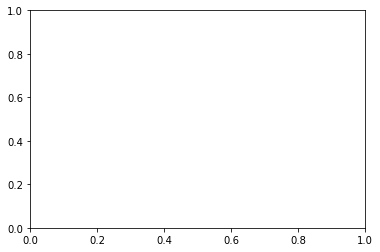

In [73]:
plt.rcParams.update({'font.size':10})
plt.plot(Metrics['bin'], Metrics['TPR'])
plt.title('Fraud Detection Rate', fontsize=20)
plt.xlim(0,10)
plt.ylim(0,1)
plt.xlabel('Score cutoff %', fontsize=15)
plt.ylabel('FDR', fontsize=15)

For a highly imbalanced problem the # goods in each bin is close to constant except for the first few bins, so the FDR curve (xaxis is bin #) and the ROC (x axis is FP, which is # goods below the cutoff) look very similar. They're only different in the first few bins where the # goods are not ~constant.

In [ ]:
plt.plot(Metrics['FPRate'], Metrics['TPR'])
plt.title('ROC', fontsize=20)
plt.xlabel('FPRate',fontsize=15)
plt.ylabel('TPRate', fontsize=15)
plt.xlim(0,1)
plt.ylim(0,1)

In [ ]:
print("duration: ", datetime.now() - start_time)

In [ ]:
%pwd

In [ ]:
%%time
df = pd.read_csv('card transactions.csv')
df.dropna(how='all', axis=1, inplace=True)
df = df[df['Transtype'] == 'P']
df = df[df['Amount'] <= 3000000]
df['Date'] = pd.to_datetime(df['Date'])
df.shape

In [ ]:
df['prediction'] = model.predict_proba(X)[:,1]

In [ ]:
pred_scale = 1/df['prediction'].max()
df['prediction'] = df['prediction']*pred_scale

In [ ]:
df.head()

In [ ]:
df.info()

In [ ]:
df_sorted = df.sort_values(by=['prediction'],ascending=False)
df_sorted.head(20)

In [ ]:
bads = df[df['Fraud']==1]
bads['Cardnum'].value_counts().head(20)

In [ ]:
bads['Merchnum'].value_counts().head(15)

In [ ]:
card = 5142140316
# card = 5142847398
# card = 5142199009
# card = 5142160778
# card = 5142189341
# card = 5142181728
# card = 5142212038
# card = 5142220919
# card = 5142214614
# card = 5142202847
# card = 5142138135
# card = 5142271065
# card = 5142152857
# card = 5142179617
# card = 5142235211
# card = 5142197711
# card = 5142182128
# card = 5142189113
# card = 5142197563 

merch = 4353000719908
# merch = 930090121224  
# merch = 48834000695423
# merch = 44503738417400
# merch = 44620009957157
# merch = 4618901687330
# merch = 4900009045549
# merch = 49108234610000
# merch = 4253052983001
# merch = 4938909877224
# merch = 44503082476300
# merch = 46006333528866
# merch = 4997674930332
# merch = 46070095870009
# merch = 49900020006406
# sample = df[df['Cardnum'] == card]
sample = df[df['Merchnum'] == str(merch)]
sample['Fraud'].sum()

In [ ]:
plt.figure(figsize=(15,5))
plt.xticks(rotation=90, ha='right')
plt.plot(sample['Date'],sample['prediction'])
plt.plot_date(sample['Date'],sample['Fraud'])

In [ ]:
tsample = sample[sample['Date'] > '2010-11-09']
tsample = tsample[tsample['Date'] < '2010-12-01']
tsample.reset_index(inplace=True)
tsample.reset_index(inplace=True)
tsample.rename(columns={'level_0':'counter'},inplace=True)
tsample['counter'] = tsample['counter']+1
tsample.head()

In [ ]:
plt.figure(figsize=(15,5))
plt.xticks(rotation=90, ha='right')
plt.plot(tsample['Date'],tsample['prediction'])
plt.plot_date(tsample['Date'],tsample['Fraud'])

In [ ]:
plt.figure(figsize=(15,5))
plt.xticks(rotation=90, ha='right')
plt.plot(tsample['counter'],tsample['prediction'])
plt.scatter(tsample['counter'],tsample['Fraud'])

In [ ]:
tsample.head(40)

# Score Calibration

In [ ]:
base = 700
delta = 40
odds_at_base = 1

In [ ]:
df = pd.concat([X_trn_eval,X_tst_eval,X_oot_eval])
df.shape

In [ ]:
df.head()

In [ ]:
calib = df.iloc[:,df.shape[1]-2:]
trn_sorted = X_trn_eval.sort_values('predicted',ascending=True)
calib = calib.sort_values('predicted')
calib.rename(columns={'predicted':'score_raw'}, inplace=True)
calib['score_raw'].clip(upper=.999, inplace=True)
calib['score_raw'].clip(lower=.00001, inplace=True)
calib.head()

In [ ]:
calib.shape

In [ ]:
plt.hist(calib['score_raw'],bins=100)
plt.yscale('log')

In [ ]:
# The reason we bin the records is to calculate the odds. We can then find the relationship between the raw score and the log odds.
nbins=100
cols = ['bin','#recs','#g','#b','%g','%b','tot','cg','cb','score_raw','prob(%)','odds','log_odds', 'log_odds_adj']
cal_bins = pd.DataFrame(np.zeros((nbins+1, 14)), columns = cols)

In [ ]:
bad_tot = sum(calib.loc[:, 'Fraud'])
good_tot = len(calib) - bad_tot
print(bad_tot, good_tot)

In [ ]:
frac = 1/nbins
nrecs = calib.shape[0]
cal_bins.loc[0,'log_odds_adj'] = -8
for i in range(nbins+1):
    percent_rows_top = int(round(nrecs*frac*i))
    percent_rows_bottom = max(int(round(nrecs*frac*(i-1))),0)
    temp = calib.iloc[percent_rows_bottom:percent_rows_top,:]
    cal_bins.loc[i, 'score_raw'] = temp['score_raw'].mean()
    num_bad = int(sum(temp.loc[:,'Fraud']))
    num_tot = len(temp) * i
    num_good = int(num_tot - num_bad)
    cal_bins.loc[i, 'bin'] = i
    cal_bins.loc[i,'#recs'] = 0
    cal_bins.loc[i, 'tot'] = num_tot
    cal_bins.loc[i, 'cg'] = num_good
    cal_bins.loc[i, 'cb'] = num_bad
    if i != 0:
        cal_bins.loc[i, '#recs'] = len(temp)
        cal_bins.loc[i, '#b'] = int(sum(temp.loc[:, 'Fraud']))
        cal_bins.loc[i, '#g'] = cal_bins.loc[i, '#recs'] - cal_bins.loc[i, '#b']
        cal_bins.loc[i, '%g'] = 100* cal_bins.loc[i, '#g'] / cal_bins.loc[i, '#recs']
        cal_bins.loc[i, '%b'] = 100 - cal_bins.loc[i, '%g']
        cal_bins.loc[i, 'cg'] = cal_bins.loc[i-1, 'cg'] + cal_bins.loc[i, '#g']
        cal_bins.loc[i, 'cb'] = cal_bins.loc[i-1, 'cb'] + cal_bins.loc[i, '#b']
        cal_bins.loc[i, 'prob(%)'] = 100 * cal_bins.loc[i, '#b'] / cal_bins.loc[i, '#recs']
        cal_bins.loc[i, 'odds'] = (cal_bins.loc[i, '#b'] + .001) / cal_bins.loc[i, '#g']
        cal_bins.loc[i, 'log_odds'] = np.log(cal_bins.loc[i, 'odds'])
        cal_bins.loc[i, 'log_odds_adj'] = max(cal_bins.loc[i, 'log_odds'], cal_bins.loc[i-1, 'log_odds_adj'])
        
cal_bins.drop(index=0,axis=0,inplace=True)
cal_bins.fillna(0)

In [ ]:
cal_bins.tail()

In [ ]:
plt.plot(cal_bins['score_raw'],cal_bins['log_odds'])
plt.plot(cal_bins['score_raw'],cal_bins['log_odds_adj'])
# plt.xlim([0,1])

In [ ]:
def func(x, a, b, c):
    return c + b/(1 + np.exp(-a * x))

def funcinv(x, a, b, c):
    return -np.log(-1 + b/(x - c))/a

In [ ]:
from scipy.optimize import curve_fit
popt, pcov = curve_fit(func, cal_bins['log_odds_adj'],cal_bins['score_raw'])   
print(popt)

In [ ]:
# plt.plot(cal_bins['log_odds'],cal_bins['score'])
plt.plot(cal_bins['log_odds_adj'],cal_bins['score_raw'])
plt.plot(cal_bins['log_odds_adj'],func(cal_bins['log_odds_adj'], *popt))

In [ ]:
# look at the smooth curve fit to see if it's OK.
plt.plot(cal_bins['score_raw'], cal_bins['log_odds_adj'])
plt.plot(cal_bins['score_raw'], funcinv(cal_bins['score_raw'], *popt))

In [ ]:
# The fit looks pretty good
cal_bins['fit'] = funcinv(cal_bins['score_raw'], *popt)
cal_bins.head(10)

In [ ]:
# Here's the calibrated score
cal_bins['score_calib'] = base + delta * cal_bins['fit'] - delta * np.log2(odds_at_base)
cal_bins['score_calib'].fillna(999, inplace=True)
cal_bins['score_calib'].clip(upper=999, inplace=True)

In [ ]:
calib.head()

In [ ]:
calib['score_calib'] = base - delta * np.log2(odds_at_base) + delta * funcinv(calib['score_raw'], *popt)
calib['score_calib'].fillna(999, inplace=True)
calib['score_calib'].clip(upper=999, inplace=True)
calib.head()

In [ ]:
calib.tail()

In [ ]:
calib.describe()

In [ ]:
nbins=100
plt.hist(calib['score_raw'],bins=nbins)
plt.yscale('log')

In [ ]:
plt.hist(calib['score_calib'],bins=nbins)
plt.yscale('log')

In [ ]:
goods = calib[calib['Fraud']==0]
bads = calib[calib['Fraud']==1]
plt.hist(goods['score_raw'],bins = nbins, alpha = .5)
plt.hist(bads['score_raw'],bins = nbins, alpha = .5)
plt.yscale('log')

In [ ]:
plt.hist(goods['score_calib'],bins = nbins, alpha = .5)
plt.hist(bads['score_calib'],bins = nbins, alpha = .5)
plt.yscale('log')

In [ ]:
print("duration: ", datetime.now() - start_time)

In [ ]:
%pwd